In [1]:
import pandas as pd
import numpy as np
import scipy
import qpsolvers
import datetime as dt
from matplotlib import pyplot as plt
from typing import Tuple
import sys
import time
sys.path.insert(1, '../src')

from helper_functions import *
from covariance import Covariance
from optimization import *
from optimization_data import OptimizationData
import qp_problems
import json
from constraints import Constraints

In [2]:
ignored_solvers = {'gurobi', # Restricted license - for non-production use only - expires 2025-11-24
                    'mosek', # License cannot be located.
                    'ecos', # LinAlgError: 0-dimensional array given. Array must be at least two-dimensional
                    'scs', # ValueError: Failed to parse cone field bu,
                    'piqp',
                    'proxqp',
                    'clarabel'
                  }
solvers = list(set(qpsolvers.solvers.available_solvers) - ignored_solvers)
universes = ['msci', 'usa']

In [3]:
# Generate constraints
def example_constraints(X):
    constraints = Constraints(selection = X)
    constraints.add_budget()

    constraints.add_linear(None, pd.Series(np.random.rand(X.size), index=X), '<=', 1)
    constraints.add_linear(None, pd.Series(np.random.rand(X.size), index=X), '>=', -1)
    constraints.add_linear(None, pd.Series(np.random.rand(X.size), index=X), '=', 0.5)
    constraints = Constraints(selection = X)

    constraints.add_linear(None, pd.Series(np.random.rand(X.size), index=X), '<=', 1)
    constraints.add_linear(None, pd.Series(np.random.rand(X.size), index=X), '>=', -1)
    constraints.add_linear(None, pd.Series(np.random.rand(X.size), index=X), '=', 0.5)

    linear_constraints = pd.DataFrame(np.random.rand(3, X.size), columns=X)
    sense = pd.Series(np.repeat('<=', 3))
    rhs = pd.Series(np.ones(3))
    constraints.add_linear(linear_constraints, None, sense, rhs, None)

    return constraints

def with_l1(X, constraints):
    constraints.add_l1('turnover', rhs = 1, x0 = dict(zip(X, np.ones(X.size)/X.shape[0])))

In [4]:
# Initialize optimization object
def prep_optim(optim, constraints, data):
    # Add constraints
    optim.constraints = constraints

    # Set objective
    optimization_data = OptimizationData(X = data['X'], y = data['y'], align = True)
    optim.set_objective(optimization_data = optimization_data)

    # Ensure that P and q are numpy arrays
    if 'P' in optim.objective.keys():
        if hasattr(optim.objective['P'], "to_numpy"):
            optim.objective['P'] = optim.objective['P'].to_numpy()
    else:
        raise ValueError("Missing matrix 'P' in objective.")
    if 'q' in optim.objective.keys():
        if hasattr(optim.objective['q'], "to_numpy"):
            optim.objective['q'] = optim.objective['q'].to_numpy()
    else:
        optim.objective['q'] = np.zeros(len(optim.constraints.selection))

    # Initialize the optimization model
    optim.model_qpsolvers()

# Small dataset msci 

In [5]:
# LOAD DATA
universe = 'msci'
data = load_data(universe)
X = data['X'].columns

In [6]:
msci_ls = {}

constraints = example_constraints(X)
constraints.add_box(box_type = 'LongOnly', upper = 0.1)
with_l1(X, constraints)

for solver in solvers:
    optim = LeastSquares(solver_name = solver)
    start = time.time()
    prep_optim(optim, constraints, data)
    optim.solve()
    runtime = time.time() - start
    solution = optim.model['solution']
    result =  {
                'solution_found' : solution.found,
                'weights' : solution.x,
                'objective_builtin' : solution.obj,
                'primal_residual' :solution.primal_residual(),
                'dual_residual' : solution.dual_residual(),
                'duality_gap' : solution.duality_gap(),
                'runtime' : runtime
              }
    result['solution'] = solution
    if not(solution.x is None) and (solution.x.any()):
        result['objective_value'] = optim.model.objective_value(solution.x)
        result['residual_Ab'] = np.abs(optim.model['A'] @ solution.x  - optim.model['b'])
        result['residual_Gh'] = np.abs(optim.model['G'] @ solution.x  - optim.model['h'])
    else :
        result['objective_value'] = None
    msci_ls[solver] = result


Text(0.5, 1.0, 'Portfolio weights')

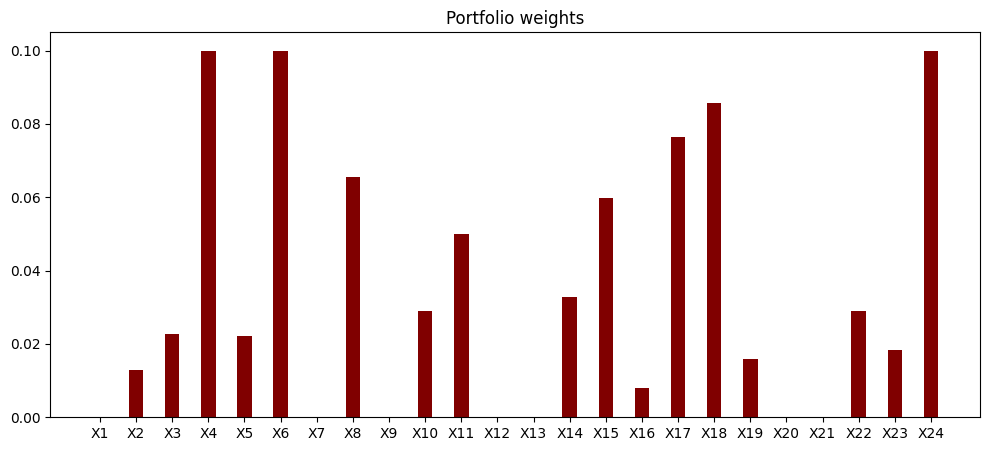

In [7]:
legends = ['X' + str(i) for i in range(1,len(X) + 1)]
plt.figure(figsize = (12, 5))
plt.bar(legends, msci_ls['cvxopt']['weights'][:len(X)], color ='maroon', width = 0.4)
plt.title('Portfolio weights')

## Comparison of different solvers 

We compare performance of solvers according to their:

* Accuracy: We evaluate objective value at solution found. 

$$\text{objective value} = 0.5*x Px + q^T x$$
* Reliability: We verify whether the sollution satisfies constraints. We compute primal_residual  and dual_residual. These residuals will be zero at the optimum.

$$\text{primal residual} = max(||Ax - b||_{\inf}, [Gx - h]^{+}, [lb - x]^{+}, [x -ub]^{+})$$ 

where $v^{+} = max(v,0)$

$$\text{dual residual} = ||Px + q + A^T y + G^T z + z_{box}  ||$$ 

where 

*    
    *  $y$ : Dual multipliers for equality constraints 

    *   $z$ : Dual multipliers for linear inequality constraints. The dimension of z is equal to the number of inequalities. 
    *   $z_{box}$ : Dual multipliers for box inequality constraints 
    

* Runtime 

In [8]:
pd.DataFrame(msci_ls).drop(index=['solution', 'weights', 'objective_builtin'])

,highs,quadprog,qpalm,cvxopt,osqp
solution_found,True,True,True,True,True
primal_residual,0.0,0.0,0.000069,0.0,0.0
dual_residual,0.0,0.0,0.0,0.0,0.00001
duality_gap,0.0,0.0,0.000017,0.0,0.000003
runtime,0.026815,0.043948,0.032795,0.036906,0.034707
objective_value,0.106114,0.106114,0.10613,0.106114,0.106114
residual_Ab,[5.551115123125783e-17],[0.0],[7.07725744131249e-06],[0.0],[9.82347758693436e-10]
residual_Gh,"[0.4946956843909086, 1.3670236117512378, 0.611...","[0.49469566778078344, 1.3670236157021645, 0.61...","[0.49464240204741483, 1.3670318958233465, 0.61...","[0.4946976092995786, 1.3670108176924667, 0.611...","[0.49465633959305877, 1.3670350944152303, 0.61..."


# Large dataset (usa)

In [9]:
# LOAD DATA
universe = 'usa'
data = load_data(universe)
X = data['X'].columns
solver_name = 'cvxopt'

In [10]:
usa_ls = {}

constraints = example_constraints(X)
constraints.add_box(box_type = 'LongOnly', upper = 0.05)
with_l1(X, constraints)

for solver in ['cvxopt']:

    optim = LeastSquares(solver_name = solver)
    start = time.time()
    prep_optim(optim, constraints, data)
    optim.solve()
    runtime = time.time() - start
    solution = optim.model['solution']
    result = {
                'solution_found' : solution.found,
                'weights' : solution.x,
                'objective_builtin' : solution.obj,
                'primal_residual' :solution.primal_residual(),
                'dual_residual' : solution.dual_residual(),
                'duality_gap' : solution.duality_gap(),
                'runtime' : runtime
            }
    result['solution'] = solution
    if not(solution.x is None) and (solution.x.any()):
        result['objective_value'] = optim.model.objective_value(solution.x)
        result['max_residual_Ab'] = max(np.abs(optim.model['A'] @ solution.x - optim.model['b']))
        result['max_residual_Gh'] = max(np.abs(optim.model['G'] @ solution.x - optim.model['h']))
    else :
        result['objective_value'] = None
    usa_ls[solver] = result


Text(0.5, 1.0, 'Portfolio weights')

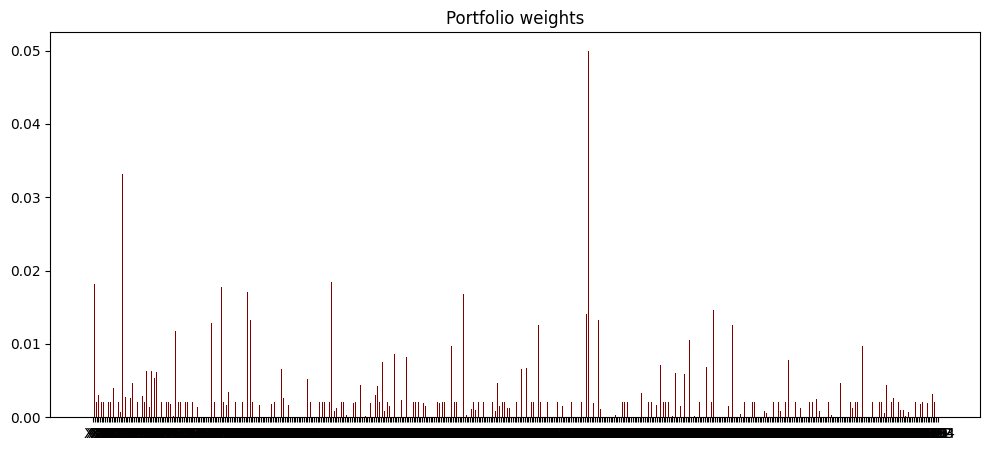

In [11]:
legends = ['X' + str(i) for i in range(1,len(X) + 1)]
plt.figure(figsize = (12, 5))
plt.bar(legends, usa_ls['cvxopt']['weights'][:len(X)], color ='maroon', width = 0.4)
plt.title('Portfolio weights')

In [12]:
pd.DataFrame(usa_ls).drop(index=['solution', 'weights', 'objective_builtin'])

,cvxopt
solution_found,True
primal_residual,0.0
dual_residual,0.0
duality_gap,0.0
runtime,2.726787
objective_value,0.009234
max_residual_Ab,0.0
max_residual_Gh,1.519759


In [13]:
features = pd.read_parquet("/home/akaboshi/minhha/GeoFin/data/usa_features.parquet")
features.head(10)

ocf_at_chg1  capx_gr2  capx_gr3  niq_at_chg1  niq_be_chg1  \
datadate   gvkey                                                               
2005-01-31 149337     0.056069 -0.894434 -0.838719     0.000224    -0.025070   
2009-09-30 012785    -0.259307 -0.202476 -0.059797     0.010776    -0.188521   
2009-05-31 012785    -0.342483 -0.003738  0.018717    -0.060742    -0.508179   
2009-06-30 012785    -0.342483 -0.003738  0.018717    -0.060742    -0.508179   
2009-10-31 012785    -0.141422 -0.325987 -0.057055     0.029241     0.384622   
2009-11-30 012785    -0.141422 -0.325987 -0.057055     0.029241     0.384622   
2024-01-31 027981     0.018893  5.078000  0.813593     0.014374     0.002138   
           013041     0.017337  0.068212 -0.333889    -0.001938    -0.027297   
           013125     0.001167       NaN       NaN    -0.019077    -0.046519   
           027780    -0.003908       NaN       NaN    -0.003770    -0.008362   

                   prc_highprc_252d  sale_gr3  capex_abn  ami_126d   z_score  \
datadate   gvkey                                                               
2005-01-31 149337          0.839216 -0.404049  -0.667650  0.258541  2.216092   
2009-09-30 012785          0.867609  0.437406  -0.301444  0.028630  2.207568   
2009-05-31 012785          0.180233  0.480856  -0.310662  0.106692  2.179904   
2009-06-30 012785          0.281285  0.480856  -0.310662  0.092487  2.179904   
2009-10-31 012785          0.809769  0.398072  -0.273433  0.018802  2.417377   
2009-11-30 012785          0.768638  0.398072  -0.273433  0.022142  2.417377   
2024-01-31 027981          0.998684  0.327879   1.266850  0.001015  3.301181   
           013041          0.850305  0.424715  -0.403778  0.000390       NaN   
           013125          0.655099  0.275742        NaN  0.000162       NaN   
           027780          0.913580  0.157143        NaN  0.000638       NaN   

                   ...  seas_1_1an  seas_1_1na  seas_11_15an  seas_11_15na  \
datadate   gvkey   ...                                                       
2005-01-31 149337  ...    0.007910    0.007192           NaN           NaN   
2009-09-30 012785  ...   -0.562249    0.261819     -0.017856      0.019107   
2009-05-31 012785  ...   -0.499775    0.094784      0.046941      0.023947   
2009-06-30 012785  ...   -0.061586    0.107030      0.056337      0.033990   
2009-10-31 012785  ...    0.055046    0.250755      0.053379      0.012577   
2009-11-30 012785  ...   -0.452174    0.287244     -0.043791      0.018885   
2024-01-31 027981  ...    0.091082    0.036909      0.144468      0.022218   
           013041  ...   -0.003337    0.004941      0.016039      0.007326   
           013125  ...   -0.114624   -0.015106     -0.025236      0.019662   
           027780  ...   -0.020513    0.006817      0.002517      0.038229   

                   seas_16_20an  seas_16_20na  seas_2_5an  seas_2_5na  \
datadate   gvkey                                                        
2005-01-31 149337           NaN           NaN         NaN         NaN   
2009-09-30 012785     -0.034473      0.011873   -0.092032   -0.015119   
2009-05-31 012785     -0.036644      0.011322    0.020576    0.004926   
2009-06-30 012785      0.075221     -0.001294   -0.012259   -0.005203   
2009-10-31 012785     -0.040146      0.015459    0.038789   -0.039756   
2009-11-30 012785     -0.033470      0.016480    0.062269   -0.046069   
2024-01-31 027981      0.058754     -0.019044    0.063204    0.021413   
           013041     -0.017544     -0.008059    0.036096    0.011753   
           013125     -0.025581      0.009757   -0.061882    0.009864   
           027780      0.010547     -0.017508    0.044965    0.012434   

                   seas_6_10an  seas_6_10na  
datadate   gvkey                             
2005-01-31 149337          NaN          NaN  
2009-09-30 012785    -0.074788     0.036930  
2009-05-31 012785     0.094852     0.016249  
2009-06-30 012785    -0.010595     0.019036  
2009-10

In [14]:
features.describe()

,ocf_at_chg1,capx_gr2,capx_gr3,niq_at_chg1,niq_be_chg1,prc_highprc_252d,sale_gr3,capex_abn,ami_126d,z_score,...,seas_1_1an,seas_1_1na,seas_11_15an,seas_11_15na,seas_16_20an,seas_16_20na,seas_2_5an,seas_2_5na,seas_6_10an,seas_6_10na
count,104544.000000,99947.000000,99343.000000,104468.000000,100937.000000,103786.000000,104151.000000,99244.000000,1.038230e+05,95893.000000,...,104658.000000,104658.000000,91302.000000,91153.000000,81565.000000,81459.000000,103280.000000,103241.000000,98961.000000,98839.000000
mean,0.000102,0.394353,0.590392,0.000083,-0.007173,0.850311,2.704472,0.053404,2.161544e-03,3.891501,...,0.011949,0.012038,0.014367,0.014205,0.016499,0.015824,0.012569,0.012513,0.013640,0.013262
std,0.049678,5.455610,8.523050,0.035998,1.340008,0.152349,241.346054,0.972291,3.618911e-02,5.512752,...,0.111068,0.033697,0.050737,0.013711,0.049027,0.013640,0.053318,0.014486,0.049025,0.012914
min,-0.603768,-2.134827,-2.923913,-3.278979,-185.597222,0.008564,-0.961054,-50.593754,7.900000e-07,-55.751577,...,-0.834807,-0.274971,-0.279371,-0.063738,-0.279371,-0.063738,-0.321251,-0.081168,-0.279371,-0.063738
25%,-0.018632,-0.144910,-0.157040,-0.003828,-0.010904,0.787092,0.007462,-0.205271,5.763500e-05,1.767416,...,-0.036869,-0.002627,-0.013875,0.005997,-0.010905,0.007655,-0.014316,0.005042,-0.013444,0.005832
50%,0.000358,0.123002,0.165344,0.000156,0.000441,0.898827,0.169128,-0.015921,1.314700e-04,3.074394,...,0.011927,0.011779,0.012401,0.012575,0.014681,0.014221,0.011479,0.011792,0.011878,0.012099
75%,0.018587,0.463737,0.585656,0.004214,0.011377,0.963065,0.376904,0.190435,3.358950e-04,4.640684,...,0.058574,0.025795,0.039510,0.020678,0.041448,0.022201,0.037279,0.018845,0.037672,0.019175
max,0.693591,488.775680,904.935962,3.329955,67.558390,1.000000,41630.000000,85.279315,2.680687e+00,115.283653,...,16.250530,1.684171,0.744273,0.148627,0.744273,0.119155,3.929293,0.412939,0.703496,0.156580


In [15]:
pd.read_parquet("/home/akaboshi/minhha/GeoFin/data/usa_returns.parquet")

gvkey,001075,001078,001161,001209,001230,001300,001327,001380,001393,001440,...,158742,160211,160329,160479,160684,160776,160888,160991,161844,162129
datadate,,,,,,,,,,,,,,,,,,,,,
2005-01-03,-0.006305,0.000429,-0.027702,0.001380,-0.020603,-0.003106,-0.046660,-0.036781,-0.011527,-0.009319,...,-0.062257,-0.015169,0.051455,-0.003001,-0.001497,-0.011125,-0.046237,0.008909,0.010625,-0.007353
2005-01-04,-0.001360,-0.010071,-0.056049,-0.019121,-0.046951,-0.017847,-0.020022,0.001890,-0.002200,-0.003821,...,-0.024513,0.003993,-0.040501,0.009782,-0.011994,-0.000313,-0.024803,0.004415,0.019584,-0.054938
2005-01-05,-0.022237,-0.011472,-0.022761,0.000878,-0.022713,-0.002884,-0.002270,-0.006289,0.007497,-0.011803,...,0.002571,-0.010227,-0.005090,-0.031297,-0.039150,-0.008440,-0.040462,-0.032967,-0.012333,-0.023514
2005-01-06,-0.009051,0.022553,-0.001519,0.006141,-0.021277,-0.006653,-0.005688,0.012911,-0.017947,0.000299,...,-0.020513,-0.009759,-0.025632,0.034615,-0.013582,-0.029319,-0.007229,0.014394,-0.017605,0.020736
2005-01-07,0.007260,0.017131,0.010142,0.005406,-0.004348,-0.003786,-0.010297,-0.000250,-0.011366,-0.003881,...,0.014398,-0.009855,0.028109,0.023048,-0.019212,-0.003573,0.001214,-0.009709,-0.050844,-0.008519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-16,-0.019509,-0.001404,0.083106,-0.013933,-0.021325,-0.016559,-0.001756,-0.024547,-0.008288,-0.006258,...,0.000074,0.035594,-0.001122,-0.012277,0.003046,-0.162162,0.030496,0.011672,-0.011490,-0.012508
2024-01-17,0.000286,0.001494,0.009008,-0.001190,-0.023533,0.000910,-0.020332,-0.001446,-0.008661,-0.015436,...,-0.016357,-0.008311,-0.007158,-0.015155,-0.011184,-0.161290,-0.020221,-0.022498,-0.016517,-0.023170
2024-01-18,-0.008443,0.000790,0.015608,-0.000423,0.040167,0.011013,0.035023,-0.007097,0.005365,-0.019190,...,0.000454,0.008357,0.014208,-0.011676,0.020673,-0.015385,0.045435,-0.007524,0.026747,0.015813
